# Basic Algorithms and Exponential Weighted Forecast
Yang Xi<br>
24 Aug, 2021

## Example: Monthly Sales Data of an Item

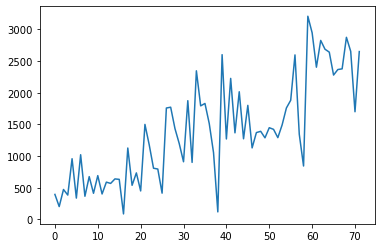

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

dfItemC = pd.read_csv('data/time_series_monthly_C.csv')
seSalesC = dfItemC['sales_qty']

plt.plot(seSalesC)

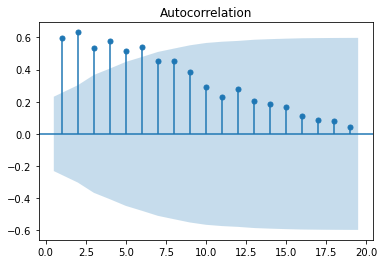

In [2]:
plotACF = plot_acf(seSalesC, fft=False, zero=False, alpha=0.05)

## Train/Test Sets and Performance Measures

In [3]:
seSalesC_train = seSalesC[dfItemC['first_date'] < '2013-01-01']
print(f"Train set contains {len(seSalesC_train)} rows.")
seSalesC_test = seSalesC[dfItemC['first_date'] >= '2013-01-01']
print(f"Test set contains {len(seSalesC_test)} rows.")

nTrain = len(seSalesC_train)
h = 12 # forecast for 12-month

def rmse_e(e, digits=2):
    return np.round(np.sqrt(np.mean(e**2)), digits)
def rmse(pred, actual, digits=2):
    return rmse_e(pred - actual, digits)

def mase(pred, actual, digits=2):
    n = len(pred)
    return np.round(np.sum(np.abs(pred-actual))/np.sum(np.abs(np.diff(actual)))*(n-1)/n, digits)

def CheckResiduals(res):
    plotACF = plot_acf(res, fft=False, zero=False, alpha=0.05)
    dfBox = acorr_ljungbox(res, lags=[len(res)-1], return_df=True)
    return plotACF, dfBox


Train set contains 60 rows.
Test set contains 12 rows.


## Simple Exponential Smoothing (SES)

In [4]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

np.random.seed(1)
fitSES = SimpleExpSmoothing(seSalesC_train.astype('double'), initialization_method='estimated').fit()
fitSES.summary()


Dep. Variable:,sales_qty,No. Observations:,60
Model:,SimpleExpSmoothing,SSE,17466305.165
Optimized:,True,AIC,758.886
Trend:,None,BIC,763.075
Seasonal:,None,AICC,759.614
Seasonal Periods:,None,Date:,"Wed, 25 Aug 2021"
Box-Cox:,False,Time:,21:53:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1891860,alpha,True
initial_level,381.00000,l.0,True


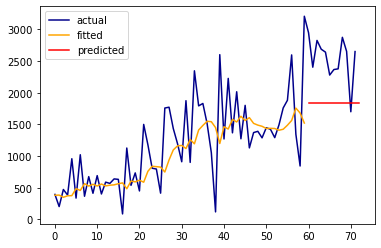

In [5]:
predSES = fitSES.predict(start=nTrain, end=nTrain+h)

line1, = plt.plot(seSalesC, color='darkblue')
line2, = plt.plot(fitSES.fittedvalues, color='orange')
line3, = plt.plot(predSES, color='red')
plt.legend([line1, line2, line3], ['actual', 'fitted', 'predicted'])

,lb_stat,lb_pvalue
59,45.790525,0.895843


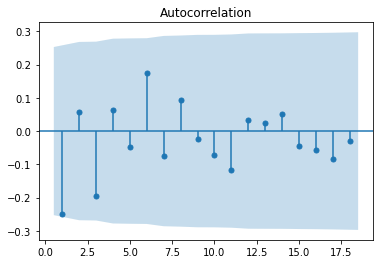

In [6]:
plotACF, dfBox = CheckResiduals(fitSES.resid)
dfBox

In [7]:
maseSES = mase(predSES, seSalesC_test)
rmseSES = rmse(predSES, seSalesC_test)
print(f"SES model: MASE = {maseSES}, RMSE = {rmseSES}.")

SES model: MASE = 1.88, RMSE = 766.17.


## Holt-Winters Model: Exponential Smoothing with Trend and Seasonality

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

np.random.seed(1)
fitHW = ExponentialSmoothing(seSalesC_train.astype('double'), \
    trend="additive", damped_trend=True,
    seasonal="multiplicative", seasonal_periods=12,
    initialization_method='estimated',
    use_boxcox = False).fit()
fitHW.summary()


Dep. Variable:,sales_qty,No. Observations:,60
Model:,ExponentialSmoothing,SSE,13073665.001
Optimized:,True,AIC,771.506
Trend:,Additive,BIC,807.110
Seasonal:,Multiplicative,AICC,790.506
Seasonal Periods:,12,Date:,"Wed, 25 Aug 2021"
Box-Cox:,False,Time:,21:53:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1464293,alpha,True
smoothing_trend,0.1464293,beta,True


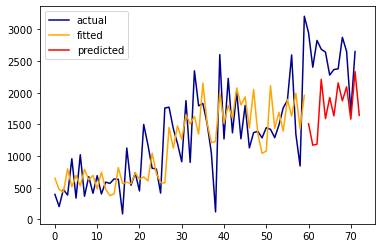

In [9]:
predHW = fitHW.predict(start=nTrain, end=nTrain+h)

line1, = plt.plot(seSalesC, color='darkblue')
line2, = plt.plot(fitHW.fittedvalues, color='orange')
line3, = plt.plot(predHW, color='red')
plt.legend([line1, line2, line3], ['actual', 'fitted', 'predicted'])

,lb_stat,lb_pvalue
59,62.872747,0.340869


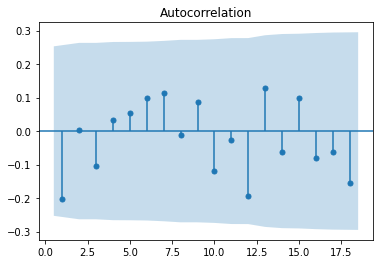

In [10]:
plotACF, dfBox = CheckResiduals(fitHW.resid)
dfBox

In [11]:
maseHW = mase(predHW, seSalesC_test)
rmseHW = rmse(predHW, seSalesC_test)
print(f"Holt-Winter's model: MASE = {maseSES}, RMSE = {rmseSES}.")

Holt-Winter's model: MASE = 1.88, RMSE = 766.17.


## ETS (error, trend, seasonal) Model: State Space Model for Exponential Smoothing

In [12]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

np.random.seed(1)
fitETS = ETSModel(seSalesC_train.astype('double'), \
    error="add", trend="add", damped_trend=True,
    seasonal="multiplicative", seasonal_periods=12,
    initialization_method='estimated'
    ).fit()
fitETS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:              sales_qty   No. Observations:                   60
Model:                      ETS(AAdM)   Log Likelihood                -450.272
Date:                Wed, 25 Aug 2021   AIC                            938.544
Time:                        21:53:56   BIC                            978.337
Sample:                             0   HQIC                           954.109
                                 - 60   Scale                       193143.892
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0516      0.352      0.147      0.883      -0.638       0.742
smoothing_trend         0.0516      0.215      0.240      0.811      -0.371       0.474
smoothing_seasonal   9.484e-05      2.196   4.32e-05      1.000      -4.304       4.304
damping_trend           0.9337      0.194      4.818      0.000       0.554       1.313
initial_level         547.8445   3557.362      0.154      0.878   -6424.458    7520.147
initial_trend           5.1210    329.996      0.016      0.988    -641.658     651.900
initial_seasonal.0      1.4382     12.528      0.115      0.909     -23.117      25.993
initial_seasonal.1      0.9523      5.489      0.173      0.862      -9.806      11.710
initial_seasonal.2      1.3209      8.943      0.148      0.883     -16.207      18.848
initial_seasonal.3      1.1137      8.706      0.128      0.898     -15.950      18.177
initial_seasonal.4      1.3611     11.772      0.116      0.908     -21.711      24.434
initial_seasonal.5      1.0389      6.673      0.156      0.876     -12.040      14.118
initial_seasonal.6      1.2549      9.584      0.131      0.896     -17.529      20.039
initial_seasonal.7      1.0420      7.778      0.134      0.893     -14.203      16.287
initial_seasonal.8      1.4796     12.867      0.115      0.908     -23.739      26.698
initial_seasonal.9      0.7114      2.750      0.259      0.796      -4.678       6.101
initial_seasonal.10     0.7333      6.080      0.121      0.904     -11.184      12.650
initial_seasonal.11     1.0000      7.473      0.134      0.894     -13.647      15.647
===================================================================================
Ljung-Box (Q):                        9.77   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.64   Prob(JB):                         0.35
Heteroskedasticity (H):               2.47   Skew:                             0.43
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

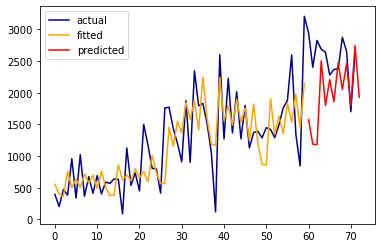

In [13]:
predETS = fitETS.predict(start=nTrain, end=nTrain+h)

line1, = plt.plot(seSalesC, color='darkblue')
line2, = plt.plot(fitETS.fittedvalues, color='orange')
line3, = plt.plot(predETS, color='red')
plt.legend([line1, line2, line3], ['actual', 'fitted', 'predicted'])

,lb_stat,lb_pvalue
59,60.540077,0.420017


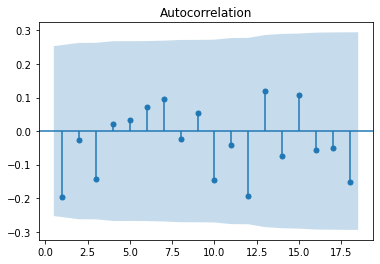

In [14]:
plotACF, dfBox = CheckResiduals(fitETS.resid)
dfBox

In [15]:
maseETS = mase(predETS, seSalesC_test)
rmseETS = rmse(predETS, seSalesC_test)
print(f"ETS model: MASE = {maseETS}, RMSE = {rmseETS}.")

ETS model: MASE = 1.56, RMSE = 807.92.
